# Определение возраста покупателей

План работы:

1. **Проведем исследовательский анализ данных**
- Посмотрим на размер выборки.
- Построим график распределения возраста в выборке.
- Напечатаем на экране 15 фотографий и посмотрим, как устроен датасет.

2. **Обучим модель и выведем ее результаты**
3. **Сформируем общий вывод**

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, Dropout, GlobalAveragePooling2D
import matplotlib.pyplot as plt

## Исследовательский анализ данных

Для начала загрузим данные и посмотрим на размер выборки.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.shape

(7591, 2)

In [5]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

Всего в выборке 7591 изображение. Для каждого изображения указан возраст человека.

Следующим шагом построим график распределения возраста в выборке.

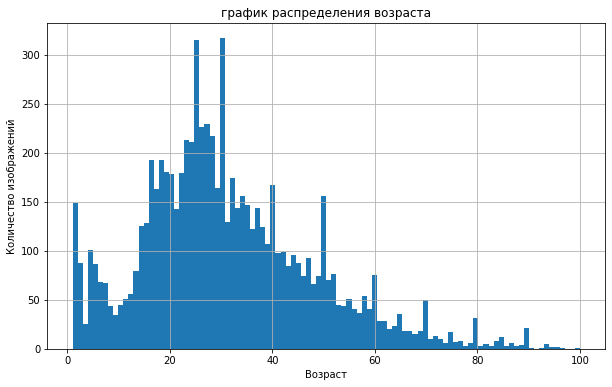

In [10]:
labels['real_age'].hist(figsize=(10, 6), bins=100)
plt.title ('График распределения возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.show()

По графику видно, что большая часть изображений в выборке соответствует людям возрастом от 10 до 50 лет. Это соответствует среднему возрасту населения. Пики в районе "юбилейных" лет, они тут могут быть связаны с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он попросту округлял его.

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Выведем на экран 15 фотографий чтобы посмотреть как устроен датасет.

In [15]:
features, target = next(train_gen_flow)

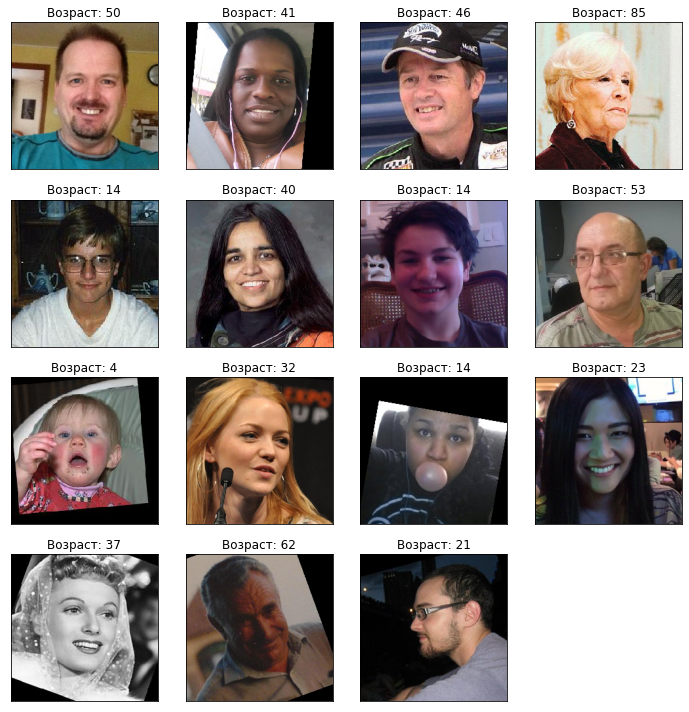

In [17]:
fig = plt.figure(figsize=(10,10))

for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Фотографии в датасете содержат изображения людей без торса, на которых видно лицо человека. Ракурсы могут отличаться, также как и меняется наличие аксессуаров (очки) на людях.

Вывод: данный датасет подойдет для выполнения задачи. В нем представлены люди разных возрастов, количество изображений достатоно для обучения модели.

## Обучение модели

Модель обучалась следующим путём:

```python
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345) 
     
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
 
def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                    weights= 'imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())    
    model.add(Dense(1, activation='relu')) 
    
    optimizer= Adam(lr = 0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])          
    
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model
```

**Вывод модели следующий:**

```
Train for 178 steps, validate for 119 steps

Epoch 1/5
178/178 - 60s - loss: 214.5195 - mae: 10.5463 - val_loss: 879.0035 - val_mae: 24.7858

Epoch 2/5
178/178 - 44s - loss: 58.4370 - mae: 5.7999 - val_loss: 635.3040 - val_mae: 20.0173

Epoch 3/5
178/178 - 43s - loss: 28.3060 - mae: 4.1152 - val_loss: 203.3377 - val_mae: 11.0828

Epoch 4/5
178/178 - 41s - loss: 17.9319 - mae: 3.2887 - val_loss: 115.7651 - val_mae: 8.3750

Epoch 5/5
178/178 - 41s - loss: 13.6422 - mae: 2.8649 - val_loss: 77.5609 - val_mae: 6.6745


119/119 - 10s - loss: 77.5609 - mae: 6.6745
Test MAE: 6.6745
```

## Анализ обученной модели

Воспользовавшись `ResNet50` наша модель, обученная на предложенном датасете, имеет показатель финальной метрики MAE **6.6745**, что ниже требуемых **8**. 

- Основа модели - `backbone = ResNet50(input_shape=input_shape, weights= 'imagenet', include_top=False)`
- Последний слой состоит из 1 нейрона с активатором Relu `Dense(1, activation='relu')`
- Оптимайзер `Adam(lr = 0.0001)`

С помощью данной модели можно успешно определять возраст покупателей, что должно позитивно сказаться на развитии Вашего магазина, а также облегчить для персонала как их работу, так и взаимодействие с покупателями.